In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv("age_gender.csv.zip")
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [6]:
df = data.drop('img_name', axis=1)
df.head()

,age,ethnicity,gender,pixels
0,1,2,0,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,202 205 209 210 209 209 210 211 212 214 218 21...


In [7]:
def basic_eda(df):
    print("\n Shape: ")
    print(df.shape)
    print("\n\n --------- ")
    print("\n Number of null values: ")
    print(df.isnull().sum())
    print("\n\n --------- ")
    print("\n Value count of age: ")
    print(df['age'].value_counts())
    print("\n\n --------- ")
    print("\n Value count of ethnicity: ")
    print(df['ethnicity'].value_counts())
    print("\n\n --------- ")
    print("\n Value count of gender: ")
    print(df['gender'].value_counts())

In [8]:
basic_eda(df)


 Shape: 
(23705, 4)


 --------- 

 Number of null values: 
age          0
ethnicity    0
gender       0
pixels       0
dtype: int64


 --------- 

 Value count of age: 
26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
101       2
91        2
111       1
103       1
Name: age, Length: 104, dtype: int64


 --------- 

 Value count of ethnicity: 
0    10078
1     4526
3     3975
2     3434
4     1692
Name: ethnicity, dtype: int64


 --------- 

 Value count of gender: 
0    12391
1    11314
Name: gender, dtype: int64


In [9]:
# Dividing target variables
columns = ["age", "gender", "ethnicity"]
y = df.drop("pixels", axis=1)
X = df.drop(columns, axis=1)

In [10]:
X.head()

,pixels
0,129 128 128 126 127 130 133 135 139 142 145 14...
1,164 74 111 168 169 171 175 182 184 188 193 199...
2,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,193 197 198 200 199 200 202 203 204 205 208 21...
4,202 205 209 210 209 209 210 211 212 214 218 21...


In [11]:
y.head()

,age,ethnicity,gender
0,1,2,0
1,1,2,0
2,1,2,0
3,1,2,0
4,1,2,0


In [12]:
y.nunique()

age          104
ethnicity      5
gender         2
dtype: int64

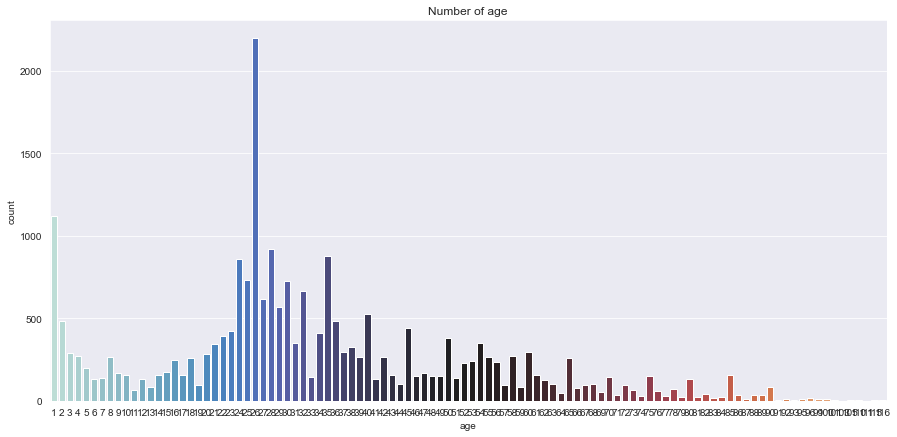

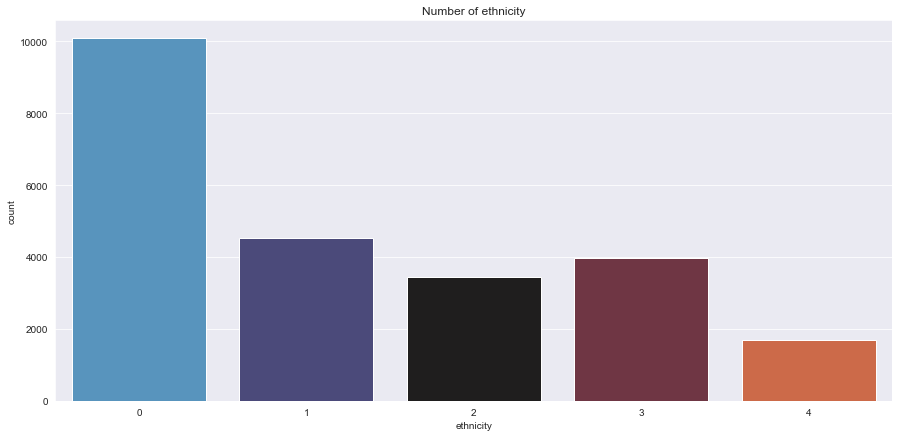

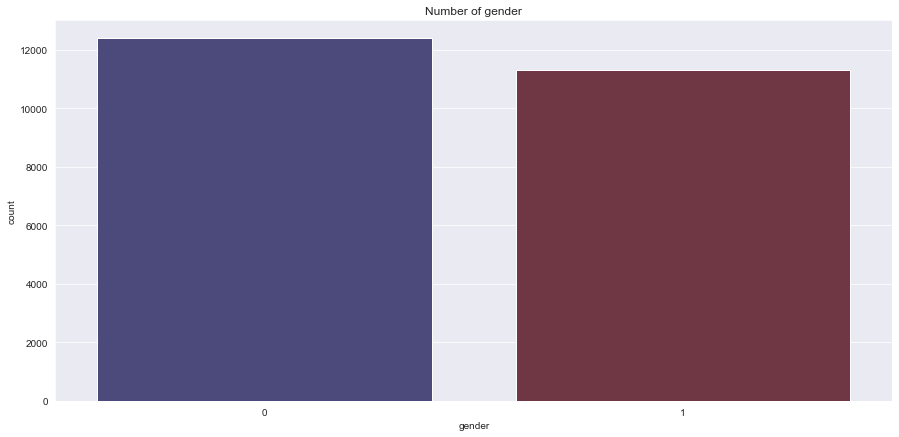

In [14]:
#data distribution and visulaization
for i in y.columns:
    plt.figure(figsize=(15,7))
    g = sns.countplot(y[i], palette="icefire")
    plt.title("Number of {}".format(i))

Text(0.5, 1.0, 'Number of age')

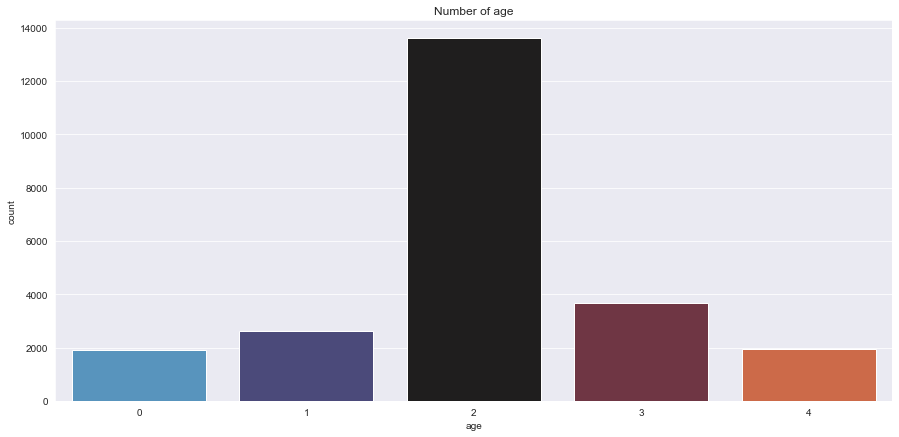

In [15]:
y["age"] = pd.cut(y["age"],bins=[0,3,18,45,64,116],labels=["0","1","2","3","4"])
plt.figure(figsize=(15,7))
g = sns.countplot(y["age"], palette="icefire")
plt.title("Number of age")

In [16]:
num_pixels = len(X['pixels'][0].split(" "))
img_height = int(np.sqrt(len(X['pixels'][0].split(" "))))
img_width = int(np.sqrt(len(X['pixels'][0].split(" "))))
print(num_pixels, img_height, img_width)

2304 48 48


In [17]:
X = pd.Series(X['pixels'])
X = X.apply(lambda x:x.split(' '))
X = X.apply(lambda x:np.array(list(map(lambda z:np.int(z), x))))
X = np.array(X)
X = np.stack(np.array(X), axis=0)

# reshape data
X = X.reshape(-1, 48, 48, 1)
print("X shape: ", X.shape)

X shape:  (23705, 48, 48, 1)


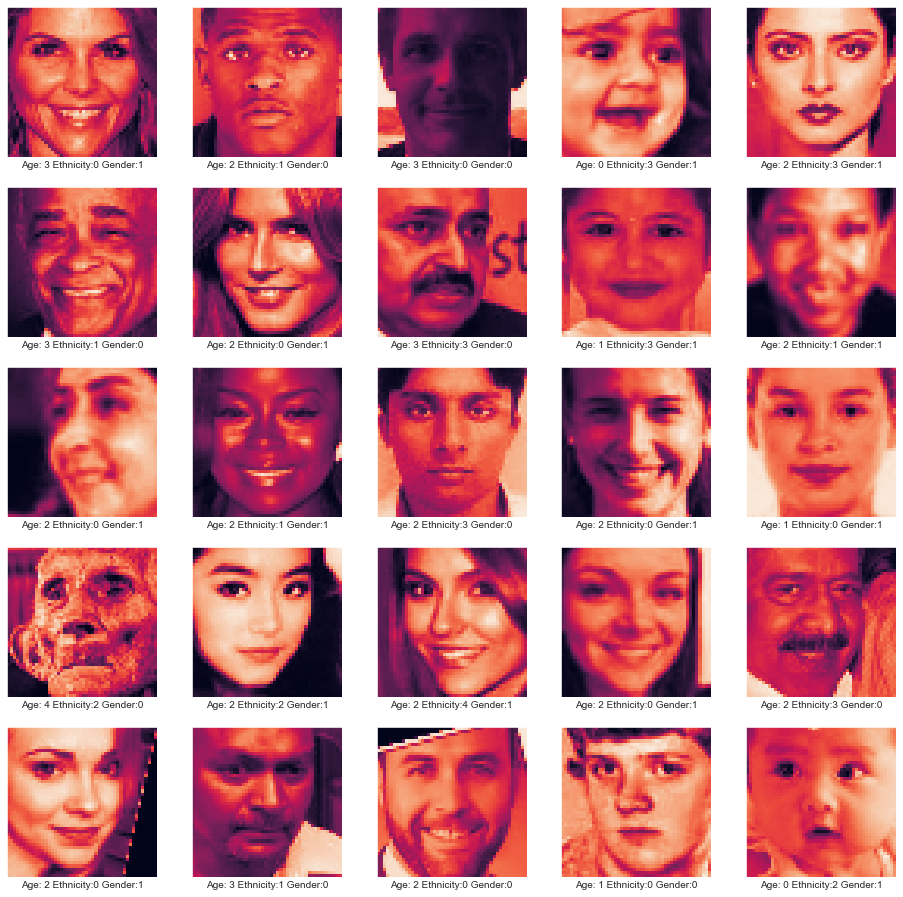

In [22]:
#Image Overview
plt.figure(figsize=(16,16))
for i,a in zip(np.random.randint(0, 23705, 25), range(1,26)):
    plt.subplot(5,5,a)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i])
    plt.xlabel(
    "Age: "+str(y['age'].iloc[i])+
    " Ethnicity:"+str(y['ethnicity'].iloc[i])+
    " Gender:"+str(y['gender'].iloc[i]))
plt.show()

In [23]:
#Building Neural Networks for AGE, GENDER AND ETHNICITY
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
import plotly.express as px
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, InputLayer
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy

In [24]:
#Categorizing target values
age_matrix = np.array(y['age'])
gender_matrix = np.array(y['gender'])
ethnicity_matrix = np.array(y['ethnicity'])
age = to_categorical(age_matrix, num_classes = 5)
gender = to_categorical(y["gender"], num_classes = 2)
ethnicity = to_categorical(ethnicity_matrix, num_classes = 5)
print(age, gender, ethnicity)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]] [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] [[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [25]:
#Normalize the data
X = X / 255
X = X / 255

In [27]:
#Image Data Generator
datagen = ImageDataGenerator(
        featurewise_center = False,
    # set input mean to 0 over the dataset
       samplewise_center = False,
    # set each sample mean to 0 
       featurewise_std_normalization = False,
    # divide inputs by std of the dataset
       samplewise_std_normalization=False,  
    # divide each input by its std
       zca_whitening=False,
    # dimesion reduction
       rotation_range=5, 
    # randomly rotate images in the range 5 degrees
       zoom_range = 0.1,
    # Randomly zoom image 10%
       width_shift_range=0.1, 
    # randomly shift images horizontally 10%
       height_shift_range=0.1,  
    # randomly shift images vertically 10%
       horizontal_flip=False,  
    # randomly flip images
        vertical_flip=False  # randomly flip images
)

datagen.fit(X)

In [28]:
#Train Test Split
# Ethnicity
from sklearn.model_selection import train_test_split
X_train_ethnicity, X_test_ethnicity, y_train_ethnicity, y_test_ethnicity = train_test_split(X,ethnicity, test_size=0.3, random_state=42)

# Gender
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(X, gender, test_size=0.3, random_state=42)

# Age
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X, age, test_size=0.3, random_state=42)

In [29]:
print(X_train_ethnicity.shape, X_train_gender.shape, X_train_age.shape)

(16593, 48, 48, 1) (16593, 48, 48, 1) (16593, 48, 48, 1)


In [30]:
#Building CNN Model
def my_model(num_classes, activation, loss):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = "same", input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(3,3),activation="relu",padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(3,3),activation="relu",padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256,activation="relu"))
    model.add(Dense(num_classes, activation=activation))
    
    model.compile(optimizer='Adam',
              loss= loss,
              metrics=['accuracy'])
    return model

In [31]:
#callbacks
early_stopping = EarlyStopping(patience=10, 
                               min_delta=0.001,
                               restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                           patience = 2,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr = 0.00001)

In [33]:
#Ethnicity Prediction
#epochs = 500  # for better result increase the epochs
epochs=20
batch_size = 64
model_ethnicity = my_model(5,"softmax",'categorical_crossentropy')
history_ethnicity = model_ethnicity.fit(X_train_ethnicity, y_train_ethnicity, batch_size=batch_size,
                              epochs = epochs, validation_data = (X_test_ethnicity,y_test_ethnicity), steps_per_epoch= X_train_ethnicity.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

Epoch 1/20
259/259 [==============================] - 82s 304ms/step - loss: 1.1997 - accuracy: 0.5662 - val_loss: 3.3657 - val_accuracy: 0.0709 - lr: 0.0010
Epoch 2/20
259/259 [==============================] - 80s 308ms/step - loss: 0.8843 - accuracy: 0.6813 - val_loss: 3.4549 - val_accuracy: 0.4644 - lr: 0.0010
Epoch 3/20
259/259 [==============================] - 70s 272ms/step - loss: 0.7864 - accuracy: 0.7218 - val_loss: 0.9823 - val_accuracy: 0.6516 - lr: 0.0010
Epoch 4/20
259/259 [==============================] - 70s 269ms/step - loss: 0.7306 - accuracy: 0.7391 - val_loss: 10.7011 - val_accuracy: 0.1437 - lr: 0.0010
Epoch 5/20
259/259 [==============================] - 69s 268ms/step - loss: 0.6903 - accuracy: 0.7542 - val_loss: 7.0011 - val_accuracy: 0.2098 - lr: 0.0010
Epoch 6/20
259/259 [==============================] - 71s 275ms/step - loss: 0.6460 - accuracy: 0.7733 - val_loss: 4.1953 - val_accuracy: 0.4581 - lr: 0.0010
Epoch 7/20
259/259 [==============================]

In [34]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [35]:
fig = px.line(
    history_ethnicity.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [37]:
#Loss & Accurac
loss, acc = model_ethnicity.evaluate(X_test_ethnicity, y_test_ethnicity, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.9823077917098999
Test Accuracy: 0.6515747904777527


In [38]:
#Age Prediction
model_age = my_model(5,"softmax",'categorical_crossentropy')
history_age = model_age.fit(X_train_age, y_train_age, batch_size=batch_size,
                              epochs = epochs, validation_data = (X_test_age,y_test_age), 
                            steps_per_epoch= X_train_age.shape[0] // batch_size, 
                            callbacks= [early_stopping, 
                            learning_rate_reduction])

Epoch 1/20
259/259 [==============================] - 73s 273ms/step - loss: 0.9421 - accuracy: 0.6538 - val_loss: 1.5205 - val_accuracy: 0.1551 - lr: 0.0010
Epoch 2/20
259/259 [==============================] - 68s 262ms/step - loss: 0.7072 - accuracy: 0.7247 - val_loss: 3.5334 - val_accuracy: 0.0828 - lr: 0.0010
Epoch 3/20
259/259 [==============================] - 69s 268ms/step - loss: 0.6499 - accuracy: 0.7489 - val_loss: 14.0405 - val_accuracy: 0.5782 - lr: 0.0010
Epoch 4/20
259/259 [==============================] - 68s 263ms/step - loss: 0.6106 - accuracy: 0.7598 - val_loss: 7.4548 - val_accuracy: 0.0828 - lr: 0.0010
Epoch 5/20
259/259 [==============================] - 67s 259ms/step - loss: 0.5849 - accuracy: 0.7688 - val_loss: 3.4685 - val_accuracy: 0.5959 - lr: 0.0010
Epoch 6/20
259/259 [==============================] - 69s 266ms/step - loss: 0.5438 - accuracy: 0.7850 - val_loss: 3.0113 - val_accuracy: 0.5782 - lr: 0.0010
Epoch 7/20
259/259 [==============================]

In [39]:
#Plotting model performance
fig = px.line(
    history_age.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [40]:
#loss and accuracy
loss, acc = model_age.evaluate(X_test_age, y_test_age, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 1.5205450057983398
Test Accuracy: 0.15508998930454254


In [41]:
#Gender Prediction
model_gender = my_model(2, "sigmoid", "binary_crossentropy")
history_gender = model_gender.fit(X_train_gender, y_train_gender, 
                                 batch_size = batch_size,
                                 epochs = epochs,
                                 validation_data = (X_test_gender, y_test_gender),
                                 steps_per_epoch = X_train_gender.shape[0] // batch_size, callbacks=[early_stopping,learning_rate_reduction])

Epoch 1/20
259/259 [==============================] - 60s 224ms/step - loss: 0.4879 - accuracy: 0.7686 - val_loss: 1.0142 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 2/20
259/259 [==============================] - 58s 219ms/step - loss: 0.3545 - accuracy: 0.8358 - val_loss: 1.1628 - val_accuracy: 0.5716 - lr: 0.0010
Epoch 3/20
259/259 [==============================] - 54s 209ms/step - loss: 0.3178 - accuracy: 0.8576 - val_loss: 0.3297 - val_accuracy: 0.8601 - lr: 0.0010
Epoch 4/20
259/259 [==============================] - 54s 210ms/step - loss: 0.3005 - accuracy: 0.8668 - val_loss: 1.0737 - val_accuracy: 0.5285 - lr: 0.0010
Epoch 5/20
259/259 [==============================] - 53s 205ms/step - loss: 0.2740 - accuracy: 0.8780 - val_loss: 2.0104 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 6/20
259/259 [==============================] - 52s 202ms/step - loss: 0.2597 - accuracy: 0.8862 - val_loss: 0.3764 - val_accuracy: 0.8219 - lr: 0.0010
Epoch 7/20
259/259 [==============================] 

In [42]:
#plot
fx = px.line(
    history_gender.history, y=["loss", "val_loss"],
    labels = {'index':'epoch', 'value':'loss'},
    title = 'Training History')

fig.show()

In [43]:
loss, acc = model_gender.evaluate(X_test_gender, y_test_gender, verbose=0)
print("Test loss: {}".format(loss))
print("Test Accuracy: {}".format(acc))

Test loss: 0.3296871781349182
Test Accuracy: 0.8600956201553345
